In [26]:
import pickle
import sys
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import artm
print artm.version()

from os import path, mkdir
from datetime import datetime
%matplotlib inline
sys.path.insert(0, '..\\modules\\helpers')
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()

In [3]:
print config.models_file_name

Q:\\topic_modeling\\csi_science_collections.git\experiments\UCI_filtered_ngramm_trimmed_without_names\np_10_12_500_sample\models.txt


In [4]:
models_file = open(config.models_file_name, 'a')

In [20]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model


def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='ngramm'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='ngramm', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='ngramm', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def create_sample_dataset_matrix(_phi, _theta):
    _phi = _phi[(_phi.T != 0).any()]
    return _phi.dot(_theta)

In [ ]:
# batch_vectorizer = artm.BatchVectorizer(data_path=config.dataset_path,
#                                         data_format='bow_uci',
#                                         collection_name=config.collection_name,
#                                         target_folder=config.output_batches_path)
# dictionary = artm.Dictionary()
# dictionary.gather(data_path=config.output_batches_path,
#                   vocab_file_path=config.vocabulary_path)
# dictionary.save(dictionary_path=config.dictionary_path)
# dictionary.save_text(dictionary_path=config.dictionary_path + '.txt')
# dictionary.load_text(dictionary_path=config.dictionary_path + '.txt')

In [34]:
# batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
#                                         data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [39]:
dictionary_path = config.dictionary_path + '.txt'

482962.0

In [49]:
with codecs.open(dictionary_path, 'r', 'utf-8') as fin:
    token_tfs, token_dfs = [], []
    fin.readline()  # skip comment line
    fin.readline()  # skip comment line
    for line in fin:
        line_list = line.split(' ')
        if line_list[1][0: -1] == u'ngramm':
            token_tfs.append(float(line_list[3][0: -1]))
            token_dfs.append(float(line_list[4][0: -1]))

In [ ]:
# dictionary.filter(min_tf=5, max_tf=2000, min_df_rate=0.01, max_df_rate=0.9)

In [7]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                         n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.01
tmp_model = fit_one_model(tmp_model, _n_iterations=15, _model_name='model1')
model1 = tmp_model; tmp_model = None

[2016-12-08 12:23:27.495000] creating model
[2016-12-08 12:23:28.714000] adding scores
[2016-12-08 12:23:28.723000] fitting
[2016-12-08 12:23:51.137000] outputting
name = model1, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 15, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.01
decorrelator_phi_regularizer, tau = 100



In [ ]:
phi1 = model1.get_phi()
theta1 = model1.get_theta()
nw = create_sample_dataset_matrix(phi1, theta1)

In [ ]:
# из сохраненных 

In [6]:
config.new_experiment_path = config.experiment_path

In [7]:
config.experiment_path = 'Q:\\topic_modeling\\csi_science_collections.git\\experiments\\UCI_filtered_ngramm_trimmed_without_names\\np_10_12_500_opt_dists_3\\'

In [18]:
# cut theta
phi_convex_hull = load_pickle_file('phi_convex_hull_t2.p')
theta = load_pickle_file('theta_t2.p')
removed_topics = set(theta.index) - set(phi_convex_hull.columns)
theta_convex_hull = theta.drop(removed_topics, axis=0)
print theta_convex_hull.shape, phi_convex_hull.shape

(449, 3446) (14929, 449)


In [21]:
nw = create_sample_dataset_matrix(phi_convex_hull, theta_convex_hull)

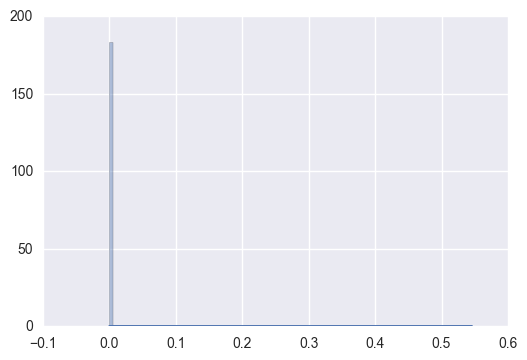

In [29]:
nws = nw.values.flatten()
sns.distplot(nws, bins=100)

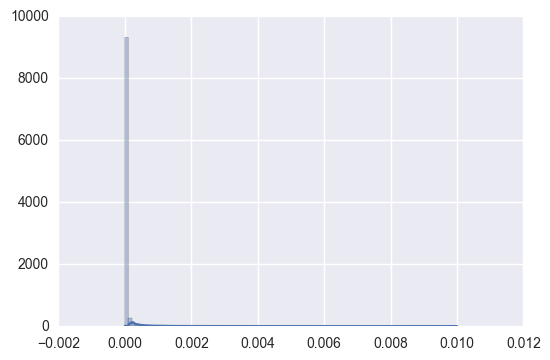

In [31]:
sns.distplot(nws[nws < 0.01], bins=100)

In [59]:
print len(nws), len(nws[nws > 0.001]), np.sum(token_dfs)

50197882 545844 482962.0


In [83]:
nw = create_sample_dataset_matrix(phi_convex_hull, theta_convex_hull)

In [ ]:
phi_convex_hull

In [85]:
nw_cut = nw.copy()
nw_cut[nw_cut < 0.001] = 0

In [91]:
s = np.sum(nw_cut)
print len(s[s > 0]), nw_cut.shape

3446 (14567, 3446)


In [92]:
output_vw_path = path.join(config.home_dir, '..\\data\postnauka\\UCI_collections', 'sample_model2')
if not path.exists(output_vw_path):
    mkdir(output_vw_path)
convert_to_vw(nw_cut, path.join(output_vw_path, 'pn.vw'))

[2016-12-11 13:36:58.241000] processing column no 0 of 3446
[2016-12-11 13:36:58.794000] processing column no 1 of 3446
[2016-12-11 13:36:59.220000] processing column no 2 of 3446
[2016-12-11 13:36:59.652000] processing column no 3 of 3446
[2016-12-11 13:37:00.090000] processing column no 4 of 3446
[2016-12-11 13:37:00.506000] processing column no 5 of 3446
[2016-12-11 13:37:00.906000] processing column no 6 of 3446
[2016-12-11 13:37:01.323000] processing column no 7 of 3446
[2016-12-11 13:37:01.798000] processing column no 8 of 3446
[2016-12-11 13:37:02.268000] processing column no 9 of 3446
[2016-12-11 13:37:02.691000] processing column no 10 of 3446
[2016-12-11 13:37:03.157000] processing column no 11 of 3446
[2016-12-11 13:37:03.715000] processing column no 12 of 3446
[2016-12-11 13:37:04.186000] processing column no 13 of 3446
[2016-12-11 13:37:04.631000] processing column no 14 of 3446
[2016-12-11 13:37:05.063000] processing column no 15 of 3446
[2016-12-11 13:37:05.480000] proce

In [93]:
nw_hull = create_sample_dataset_matrix(phi_convex_hull, theta_convex_hull)
nw_hull[nw_hull < 0.00001] = 0
for col in nw_hull:
    nw_hull[col] = nw_hull[col] / np.sum(nw_hull[col]) 

In [95]:
output_vw_path = path.join(config.home_dir, '..\\data\postnauka\\UCI_collections', 'sample_model2')
if not path.exists(output_vw_path):
    mkdir(output_vw_path)
convert_to_vw(nw_cut, path.join(output_vw_path, 'pn_hull.vw'))

[2016-12-11 14:14:25.997000] processing column no 0 of 3446
[2016-12-11 14:14:26.490000] processing column no 1 of 3446
[2016-12-11 14:14:26.919000] processing column no 2 of 3446
[2016-12-11 14:14:27.355000] processing column no 3 of 3446
[2016-12-11 14:14:27.916000] processing column no 4 of 3446
[2016-12-11 14:14:28.515000] processing column no 5 of 3446
[2016-12-11 14:14:29.095000] processing column no 6 of 3446
[2016-12-11 14:14:29.668000] processing column no 7 of 3446
[2016-12-11 14:14:30.238000] processing column no 8 of 3446
[2016-12-11 14:14:30.828000] processing column no 9 of 3446
[2016-12-11 14:14:31.376000] processing column no 10 of 3446
[2016-12-11 14:14:31.817000] processing column no 11 of 3446
[2016-12-11 14:14:32.272000] processing column no 12 of 3446
[2016-12-11 14:14:32.724000] processing column no 13 of 3446
[2016-12-11 14:14:33.182000] processing column no 14 of 3446
[2016-12-11 14:14:33.624000] processing column no 15 of 3446
[2016-12-11 14:14:34.057000] proce

In [23]:
def convert_to_vw(_nw, out_file):
    with codecs.open(out_file, 'w', 'utf-8') as fout:
        for idx, col in enumerate(_nw.columns):
            print '[{}] processing column no {} of {}'.format(datetime.now(), idx, len(_nw.columns))
            fout.write(u'doc_{} |@default_class '.format(col))
            values = _nw[col]
            for idx in values.index.values:
                val = values[idx]
                if val != 0:
                    fout.write(u'{}:{} '.format(idx, val))
            fout.write(u'\n')

In [24]:
output_vw_path = path.join(config.home_dir, '..\\data\postnauka\\UCI_collections', 'sample_model2')
if not path.exists(output_vw_path):
    mkdir(output_vw_path)
convert_to_vw(nw, path.join(output_vw_path, 'model1.vw'))

[2016-12-11 10:53:58.754000] processing column no 0 of 3446
[2016-12-11 10:53:59.419000] processing column no 1 of 3446
[2016-12-11 10:53:59.896000] processing column no 2 of 3446
[2016-12-11 10:54:00.344000] processing column no 3 of 3446
[2016-12-11 10:54:00.845000] processing column no 4 of 3446
[2016-12-11 10:54:01.343000] processing column no 5 of 3446
[2016-12-11 10:54:01.848000] processing column no 6 of 3446
[2016-12-11 10:54:02.502000] processing column no 7 of 3446
[2016-12-11 10:54:02.971000] processing column no 8 of 3446
[2016-12-11 10:54:03.450000] processing column no 9 of 3446
[2016-12-11 10:54:03.851000] processing column no 10 of 3446
[2016-12-11 10:54:04.321000] processing column no 11 of 3446
[2016-12-11 10:54:04.836000] processing column no 12 of 3446
[2016-12-11 10:54:05.385000] processing column no 13 of 3446
[2016-12-11 10:54:05.986000] processing column no 14 of 3446
[2016-12-11 10:54:06.529000] processing column no 15 of 3446
[2016-12-11 10:54:07.143000] proce

In [25]:
models_file.close()